# Загрузка библиотек


In [ ]:
!pip install optuna
!pip install shap
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import warnings
import optuna
import shap
import joblib
import re
import eli5
from eli5.sklearn import PermutationImportance
from typing import List
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

In [ ]:
RAND = 42
N_folds = 5

# Загрузка данных

In [ ]:
data_3 = pd.read_excel(
    '/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/raw_data/Копия Database_3.xlsx')

In [ ]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Publication year          4111 non-null   float64
 1   Material                  4111 non-null   object 
 2   Type                      4111 non-null   object 
 3   Shape                     4111 non-null   object 
 4   Coat_Functional Group     4110 non-null   object 
 5   Synthesis_Method          4111 non-null   object 
 6   Diameter_nm               3278 non-null   float64
 7   Hydro size_nm             2330 non-null   float64
 8   Size_in_Medium_nm         1989 non-null   float64
 9   Surface charge_mV         2487 non-null   object 
 10  Zeta_in_Medium            1670 non-null   float64
 11  Cell type                 4111 non-null   object 
 12  No_of_Cells               3684 non-null   float64
 13  Human_Animal_cells        4111 non-null   object 
 14  Cell_Sou

# Методы

In [ ]:
def correlation_features_to_drop(data: pd.DataFrame,
                                 method: str,
                                 weak_value: float,
                                 strong_value: float,
                                 figsize: tuple,
                                 plot: bool) -> List:
    """
    Function for generating a list of strongly correlated features, and outputting a Heatmap
    :param data: you data
    :param method: method of calculate correlation ex: 'spearman' or 'pearson'
    :param weak_value: threshold of weak correlation
    :param strong_value: threshold of strong correlation
    :param figsize: size of heatmap
    :param plot: whether to draw a Heatmap
    :return: list of name features to drop
    """
    corr = data.corr(method=method)
    corr_matrix = corr
    corr_matrix[corr_matrix < abs(weak_value)] = 0
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

    to_drop = [cols for cols in upper.columns if any(upper[cols] > strong_value)]

    if plot:
        plt.figure(figsize=figsize)
        sns.heatmap(corr_matrix, annot=True, mask=mask)

    return to_drop

In [ ]:
def r2_adjusted(y_true: list, y_pred: list, x_test: np.array) -> float:
    N_objects = len(y_true)
    N_features = x_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: list, y_pred: list) -> float:
    return np.mean((y_true - y_pred)/ y_true)


def mape(y_true: list, y_pred: list) -> float:
    return np.mean(np.abs((y_pred - y_true) / y_true))


def wape(y_true: list, y_pred: list) -> float:
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true)


def huber_loss(y_true, y_pred, delta):
    assert len(y_true) == len(y_pred), 'Разные размеры данных'
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) < delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i])**2
        else:
            huber_sum += delta * (0.5 * abs(y_true[i] - y_pred[i]) -
                                  0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
def get_metrics_regression(y_test: pd.DataFrame, 
                           y_pred: np.array, 
                           x_test: np.array,
                           name: str, 
                           delta: int) -> pd.DataFrame:
    """
    Calculate different classification metrics
    :param y_test: true labels
    :param y_pred: model predict labels
    :param name: name of model
    :return: result of calculation
    """
    df_metrics = pd.DataFrame()
    
    df_metrics['model'] = [name]
    
    df_metrics['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df_metrics['MSE'] = [mean_squared_error(y_test, y_pred)]
    df_metrics['RMSE'] = [np.sqrt(mean_squared_error(y_test, y_pred))]
    
    try:
        df_metrics['RMSLE'] = [rmsle(y_test, y_pred)]
    except:
        df_metrics['RMSLE'] = 0

    df_metrics['R2 adjusted'] = [r2_adjusted(y_test, y_pred, x_test)]
    df_metrics['Huber_loss'] = [huber_loss(y_test, y_pred, delta)]
    df_metrics['MPE_%'] = [mpe(y_test, y_pred)*100]
    df_metrics['MAPE_%'] = [mape(y_test, y_pred)*100]
    df_metrics['WAPE_%'] = [wape(y_test, y_pred)*100]

    return df_metrics

In [ ]:
def base_models_fit_compare_regression(dict_of_models: dict,
                                      x_train: pd.DataFrame,
                                      y_train: np.array,
                                      x_test: pd.DataFrame,
                                      y_test: np.array) -> pd.DataFrame:
    """
    Function for quick comparison of metrics of base models, for subsequent selection
    :param dict_of_models: dict of models for comparison
    :param x_train: train data
    :param y_train: train labels
    :param x_test: test data
    :param y_test: test labels
    :return: DataFrame with calculated metrics for each model
    """
    metrics = pd.DataFrame()

    for i in tqdm_notebook(dict_of_models):
      
        model = dict_of_models[i]
        
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        metrics = metrics.append(get_metrics_regression(y_test, y_pred, x_test, i, 1))

    return metrics

In [ ]:
def removal_outliers(data: pd.DataFrame, 
                     columns: list, 
                     min_q: float, 
                     max_q: float) -> pd.DataFrame:
  """
  Function for remove outliers
  :param data: you data
  :param columns: columns with outliers
  :param min_q: Q1 percentile values
  :param max_q: Q3 percentile values
  :return: list of name features to drop
  """
  df = data.copy()
  plt.figure(figsize=(30, 20))

  for i, col in enumerate(columns):

    Q1 = df[col].quantile(min_q)
    Q3 = df[col].quantile(max_q)

    df[col] = df[(df[col] > Q1) & (df[col] < Q3)][col]

    plt.subplot(4, 3, i+1)
    sns.boxplot(x=col, data=df)

  df.dropna(inplace=True)
  
  return df

# EDA

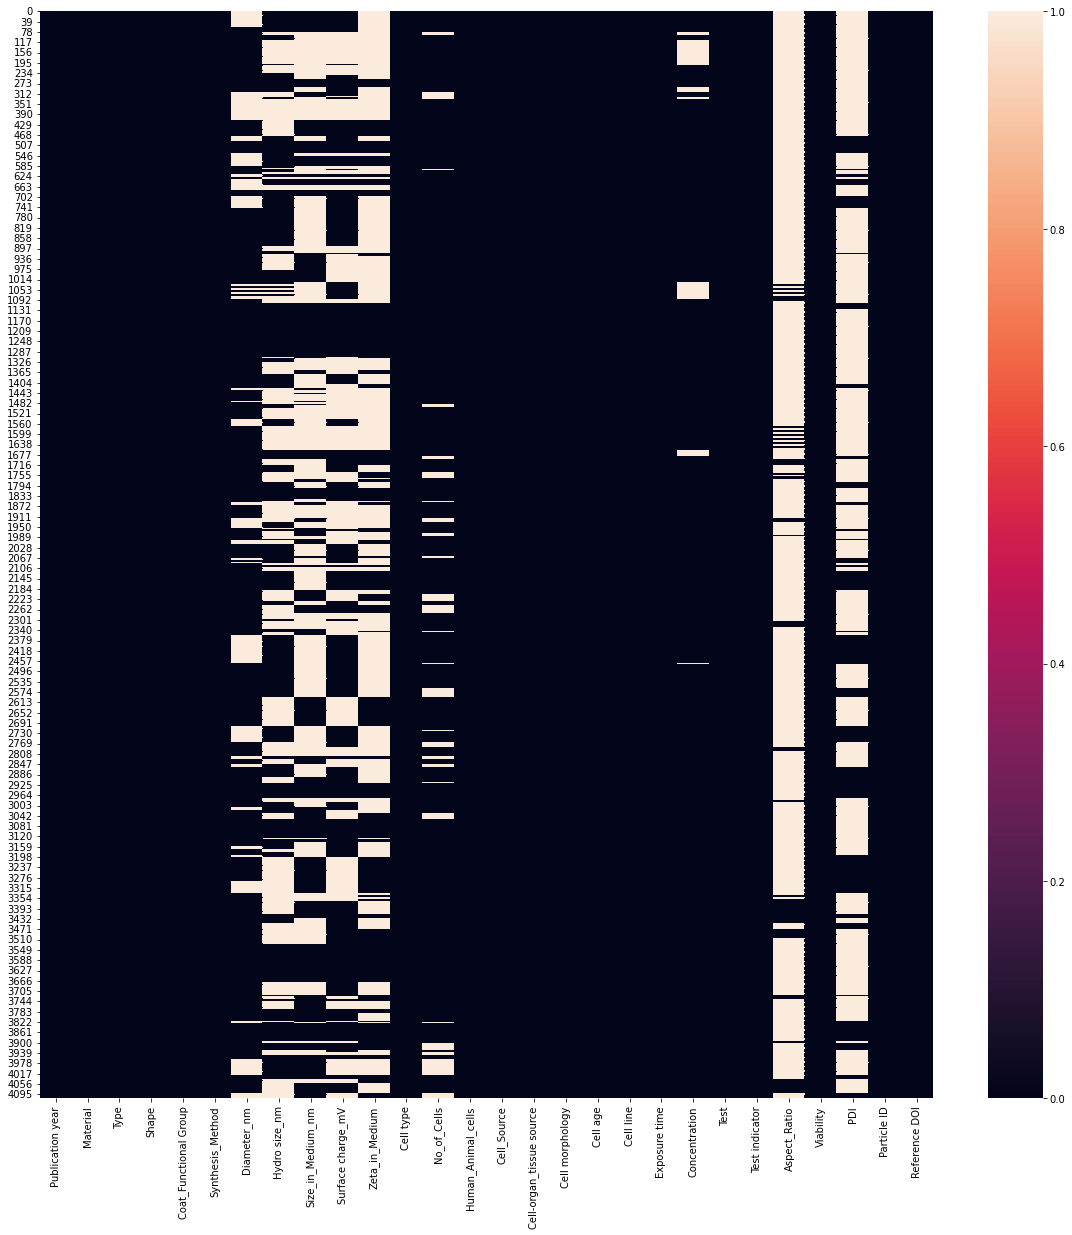

In [ ]:
# визуальная оценка пропусков
plt.figure(figsize=(20, 20))
sns.heatmap(data_3.isna());

In [ ]:
# удаляем малоинформативные колонки с пропусками
data_3.drop(['Publication year', 
             'Size_in_Medium_nm', 
             'Zeta_in_Medium', 
             'Aspect_Ratio', 
             'PDI', 
             'Reference DOI',
             'Particle ID'], axis=1, inplace=True)

In [ ]:
# удаляем строки с пропусками
data_3.dropna(inplace=True)

In [ ]:
data_3['Surface charge_mV'] = data_3['Surface charge_mV'].astype('float32')

In [ ]:
features = data_3.select_dtypes(exclude='object').columns.to_list()

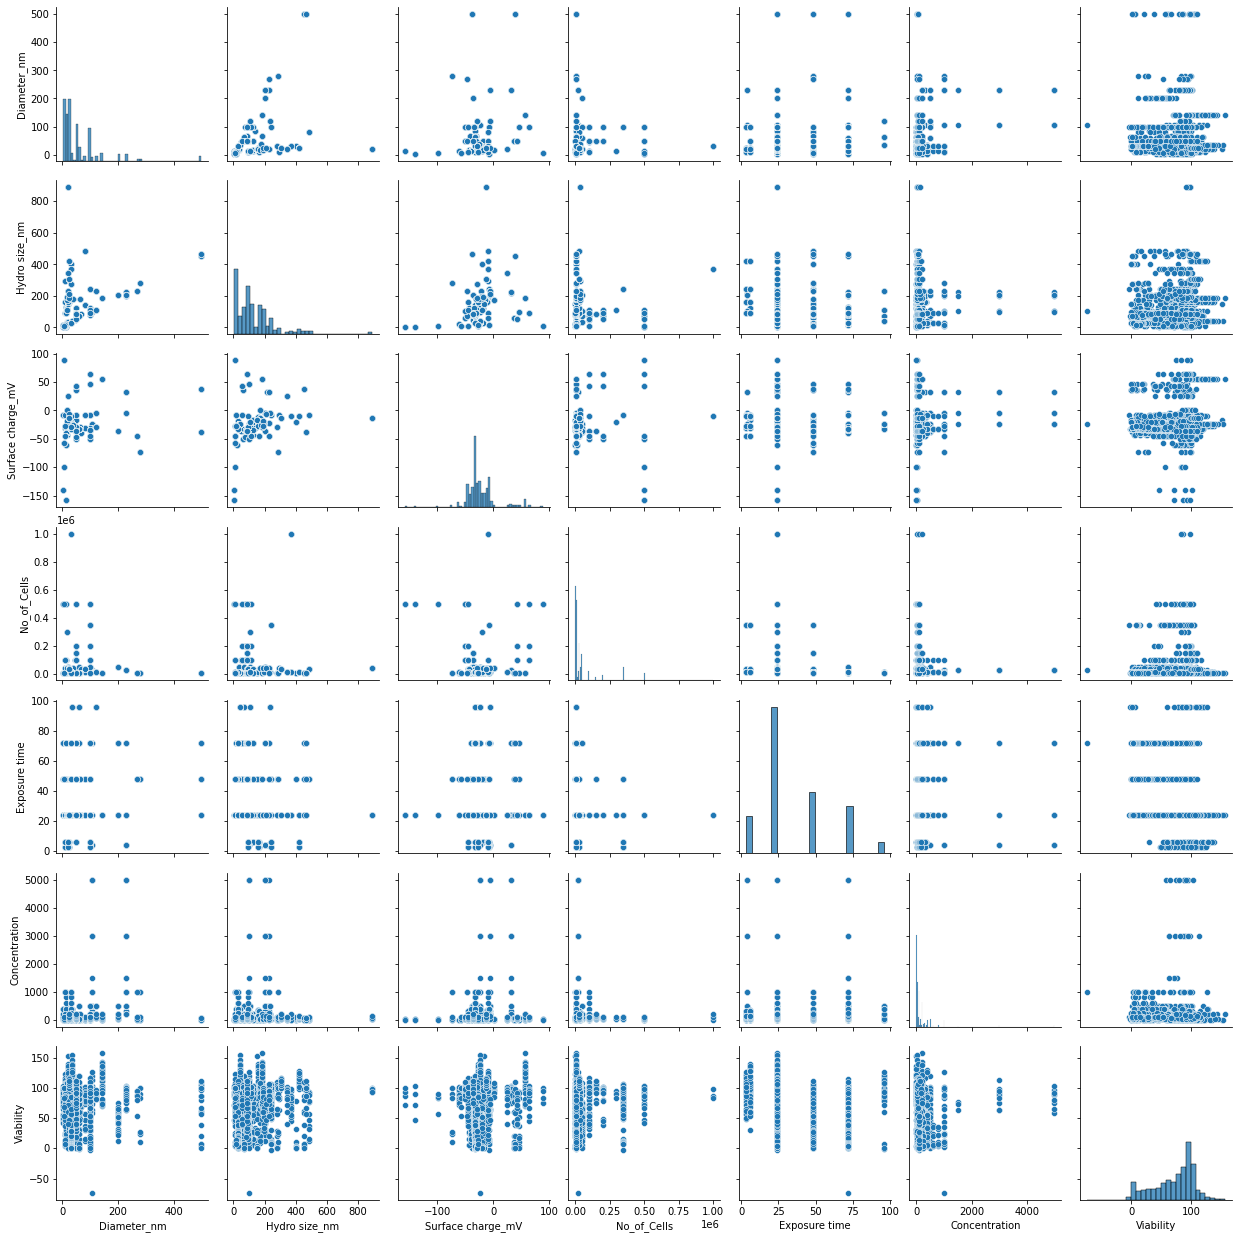

In [ ]:
sns.pairplot(data_3, vars=features);

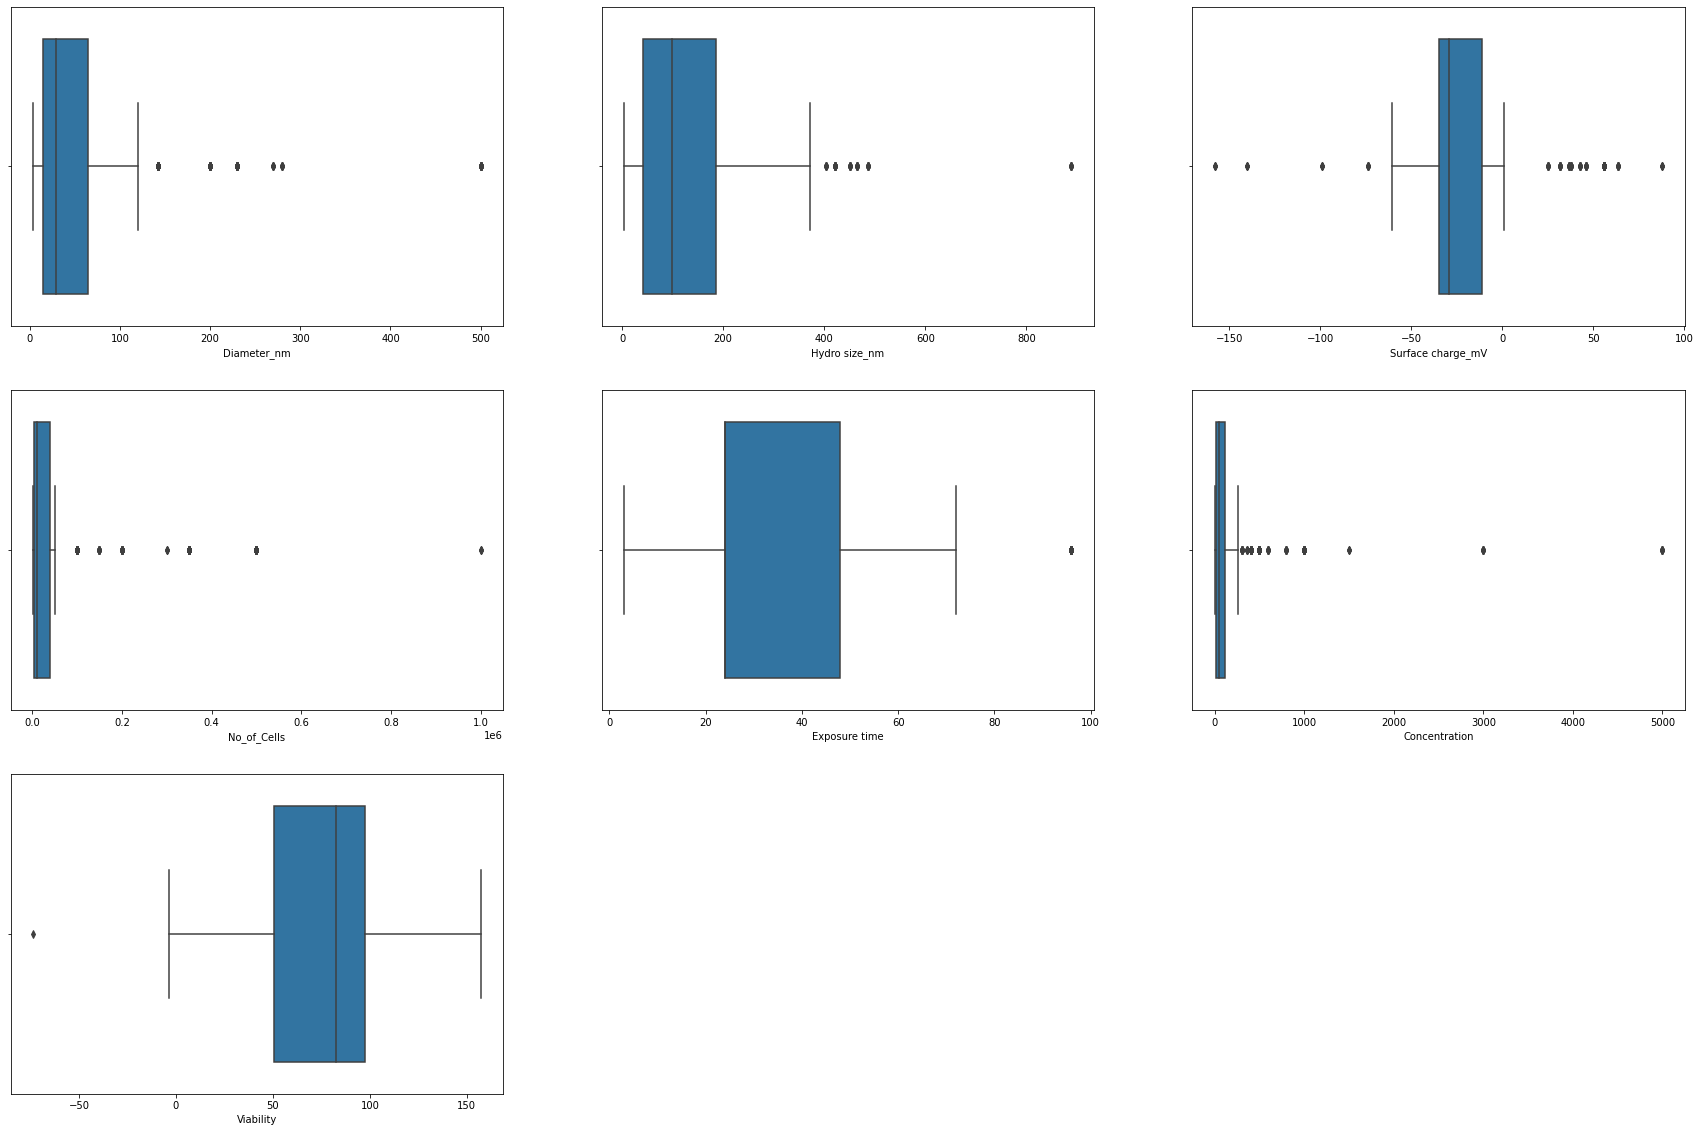

In [ ]:
# оценка выбросов
plt.figure(figsize=(30, 20))
for i, j in enumerate(data_3.select_dtypes(exclude='object')):
  plt.subplot(3, 3, i+1)
  sns.boxplot(x=j, data=data_3)

In [ ]:
# колонки с выбросами
columns_to_clean = ['Diameter_nm', 'No_of_Cells', 'Concentration']

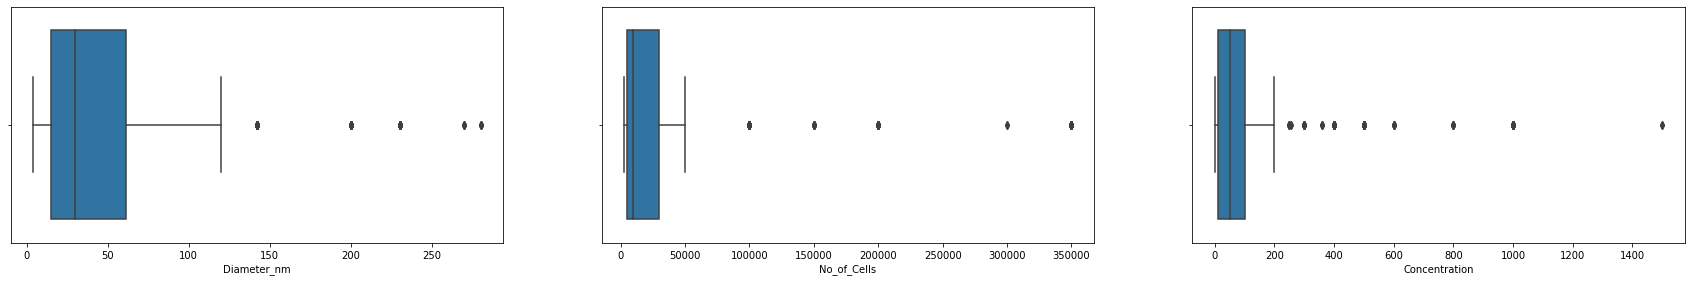

In [ ]:
# удаляем выбросы
data_3 = removal_outliers(data_3, columns_to_clean, 0, 0.99)

In [ ]:
# Удалим отрицательные значения и значения > 100 сделаем 100
data_3['Viability'] = abs(data_3['Viability'])
data_3[data_3['Viability'] > 100]['Viability'] = 100

In [ ]:
# удаляем опечатки
data_3['Shape'] = data_3.apply(lambda x: re.sub('Iregular', 'Irregular', x['Shape']), axis=1)

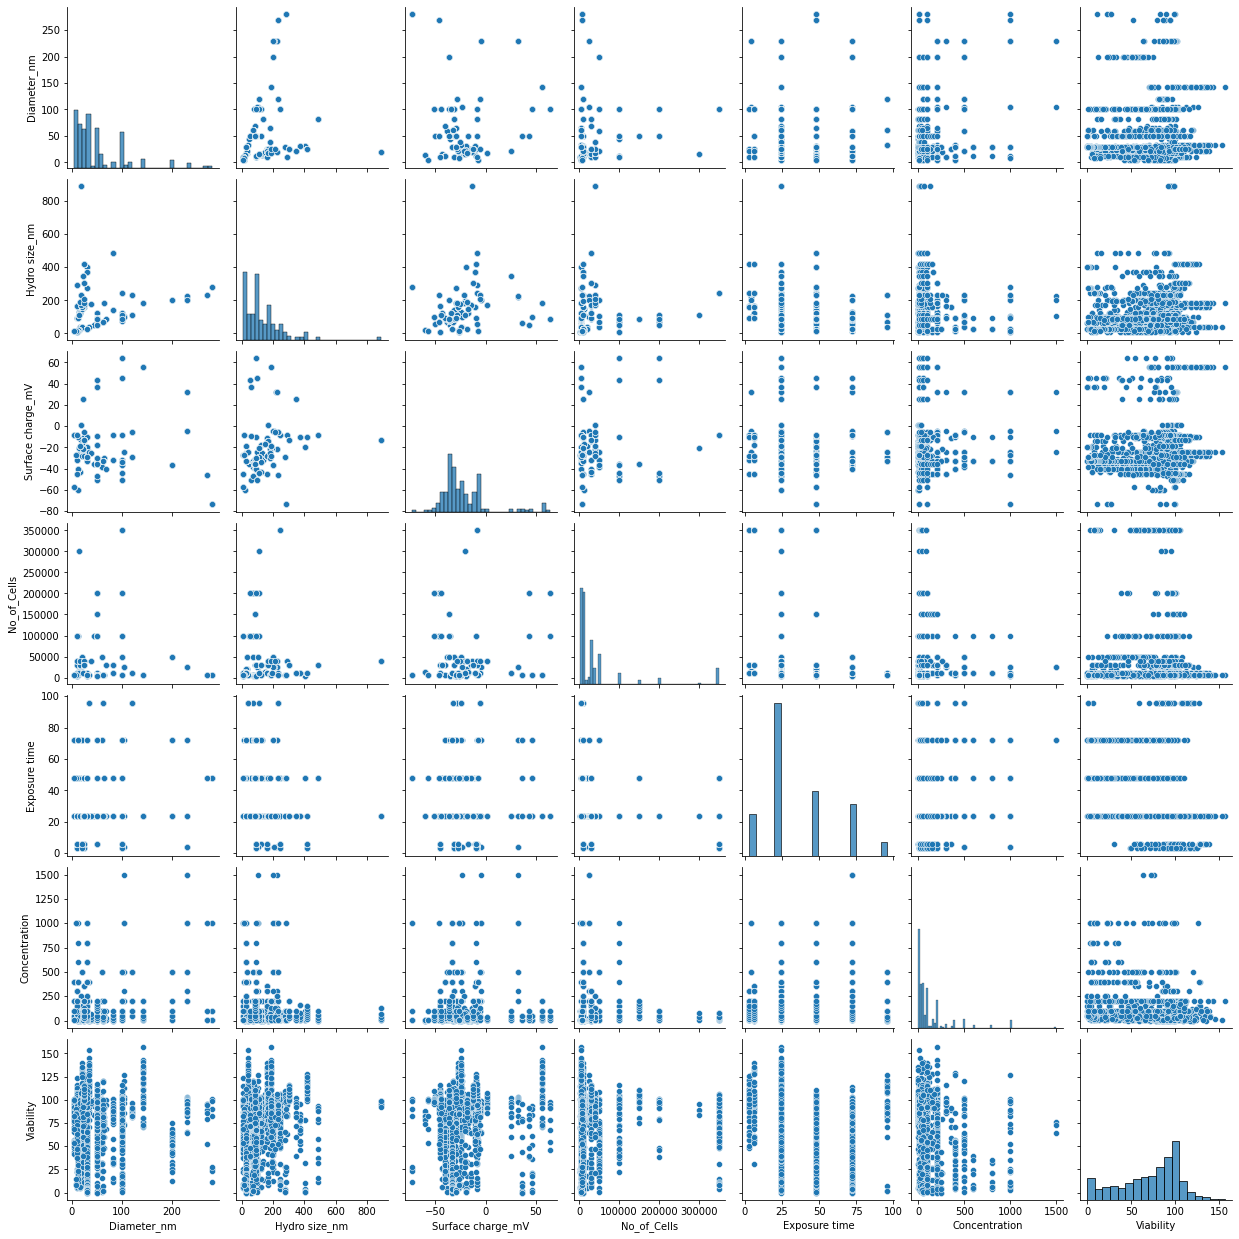

In [ ]:
sns.pairplot(data_3, vars=features);

[]

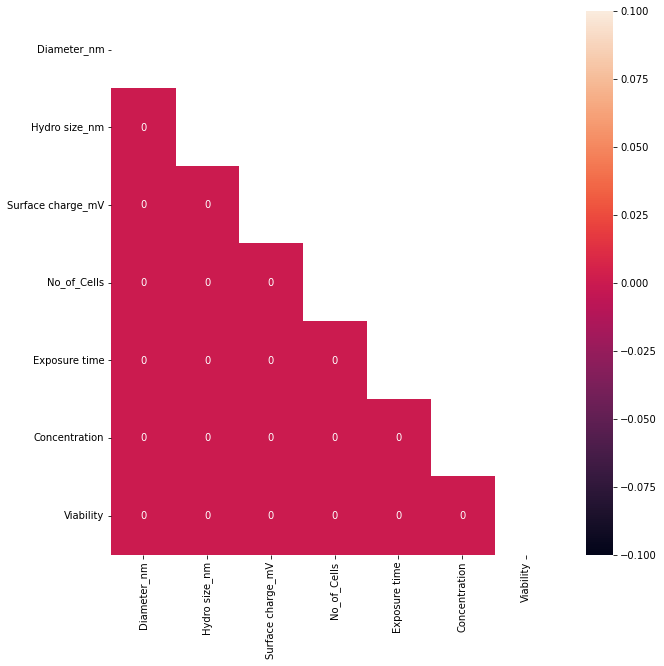

In [ ]:
correlation_features_to_drop(data=data_3, 
                             method='pearson', 
                             weak_value=0.3, 
                             strong_value=0.7, 
                             figsize=(10,10), 
                             plot=True)

# Подготовка данных

In [ ]:
X = data_3.drop('Viability', axis=1)
y = data_3['Viability'].values

In [ ]:
for i in X.select_dtypes(include='object').columns:
  X[i] = X[i].astype('category').cat.codes

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Сравнение бейзлайнов

In [ ]:
models = {'LR': LinearRegression(), 
          'SVR': SVR(), 
          'RF': RandomForestRegressor(),
          'Lasso': Lasso(),
          'Ridge': Ridge(),
          'Elastic_net': ElasticNet()}

In [ ]:
base_models_fit_compare_regression(models, x_train, y_train, x_test, y_test)

  0%|          | 0/6 [00:00<?, ?it/s]

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,LR,21.110294,756.425891,27.503198,0.872982,0.179768,10.055147,-inf,inf,28.310090
0,SVR,18.734447,735.252638,27.115542,0.908181,0.202728,8.888675,-inf,inf,25.123946
0,RF,8.381145,211.674236,14.549029,0.532243,0.770471,3.750908,-inf,inf,11.239586
0,Lasso,21.771128,795.654286,28.207345,0.878405,0.137231,10.405467,-inf,inf,29.196306
0,Ridge,21.096890,756.955053,27.512816,0.872828,0.179195,10.048445,-inf,inf,28.292114
0,Elastic_net,22.718994,815.100365,28.549963,0.883332,0.116145,10.875957,-inf,inf,30.467447


#Tuning

In [ ]:
def objective(trial, X, y, N_FOLDS, random_state):
    
    rf_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [30, 50, 100, 200]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2']),
        "criterion": trial.suggest_categorical("criterion", ['mse']),
        "random_state": 42}
    
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = RandomForestRegressor(**rf_params)
        model.fit(X_train,
                  y_train)
        
        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="RF")
func = lambda trial: objective(trial, x_train, y_train, N_FOLDS=N_folds, random_state=RAND)
study.optimize(func, n_trials=30, show_progress_bar=True)

[I 2022-09-08 12:20:23,316] A new study created in memory with name: RF


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-09-08 12:20:24,427] Trial 0 finished with value: 9.151322477124427 and parameters: {'n_estimators': 100, 'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'criterion': 'mse'}. Best is trial 0 with value: 9.151322477124427.
[I 2022-09-08 12:20:24,920] Trial 1 finished with value: 13.57270822376934 and parameters: {'n_estimators': 30, 'bootstrap': False, 'max_depth': 6, 'max_features': 'auto', 'criterion': 'mse'}. Best is trial 0 with value: 9.151322477124427.
[I 2022-09-08 12:20:25,412] Trial 2 finished with value: 15.282124049401427 and parameters: {'n_estimators': 50, 'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'criterion': 'mse'}. Best is trial 0 with value: 9.151322477124427.
[I 2022-09-08 12:20:26,419] Trial 3 finished with value: 9.151322477124427 and parameters: {'n_estimators': 100, 'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'criterion': 'mse'}. Best is trial 0 with value: 9.151322477124427.
[I 2022-09-08 12:20:28,543] Trial 4 

In [ ]:
study.best_params

{'n_estimators': 100,
 'bootstrap': False,
 'max_depth': 10,
 'max_features': 'log2',
 'criterion': 'mse'}

# Обучение модели

In [ ]:
cv = KFold(n_splits=N_folds, shuffle=True, random_state=RAND)

In [ ]:
score_oof = []
predicts_test = []


for fold, (train_index, test_index) in enumerate(cv.split(x_train, y_train)):
    X_train_, X_val = x_train[train_index], x_train[test_index]
    y_train_, y_val = y_train[train_index], y_train[test_index]

    model = RandomForestRegressor(**study.best_params)
    model.fit(X_train_, y_train_)

    y_prob_val = model.predict(X_val)
    y_prob_test = model.predict(x_test)
    
    print(
        "Fold:", fold + 1, "MAE Validation %.3f" %
        mean_absolute_error(y_val, y_prob_val))
    print("---")

    score_oof.append(mean_absolute_error(y_val, y_prob_val))
    
    predicts_test.append(y_prob_test)

Fold: 1 MAE Validation 8.746
---
Fold: 2 MAE Validation 9.341
---
Fold: 3 MAE Validation 9.630
---
Fold: 4 MAE Validation 9.163
---
Fold: 5 MAE Validation 8.765
---


In [ ]:
test_pred = np.mean(predicts_test, axis=0)
print(f'МAE = {mean_absolute_error(y_test, test_pred)}')
print(f'WAPE = {wape(y_test, test_pred)}')

МAE = 9.008871508263248
WAPE = 0.12081402762524782


# Сохранение модели и параметров

In [ ]:
need_save = True
if need_save:
  joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/Models/RF_model.xz')
  # joblib.dump(study.best_params, '/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/Models/RF_params_1.json')
  joblib.dump(study.best_params, '/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/Models/RF_params_2.json')

# Load model

In [ ]:
model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/Models/RF_model.xz')
model_params = joblib.load('/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/Models/RF_params_2.json')

# Feature importance

In [ ]:
# Через пермутэйшн
perm = PermutationImportance(model, random_state=RAND, n_iter=2)
perm.fit(x_train, y_train)

eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.4030 ± 0.0625,Concentration
0.2228 ± 0.0246,Exposure time
0.1209 ± 0.0031,Hydro size_nm
0.1035 ± 0.0028,Surface charge_mV
0.0750 ± 0.0009,Material
0.0496 ± 0.0025,No_of_Cells
0.0490 ± 0.0047,Cell-organ_tissue source
0.0470 ± 0.0031,Coat_Functional Group
0.0395 ± 0.0015,Diameter_nm
0.0377 ± 0.0018,Test


In [ ]:
# встроенный
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_}).sort_values(
        by='importance', ascending=False)

In [ ]:
importances

,feature,importance
17,Concentration,0.183387
16,Exposure time,0.126645
6,Hydro size_nm,0.115196
7,Surface charge_mV,0.087668
0,Material,0.068876
12,Cell-organ_tissue source,0.050997
5,Diameter_nm,0.050244
3,Coat_Functional Group,0.050225
9,No_of_Cells,0.047404
8,Cell type,0.043534


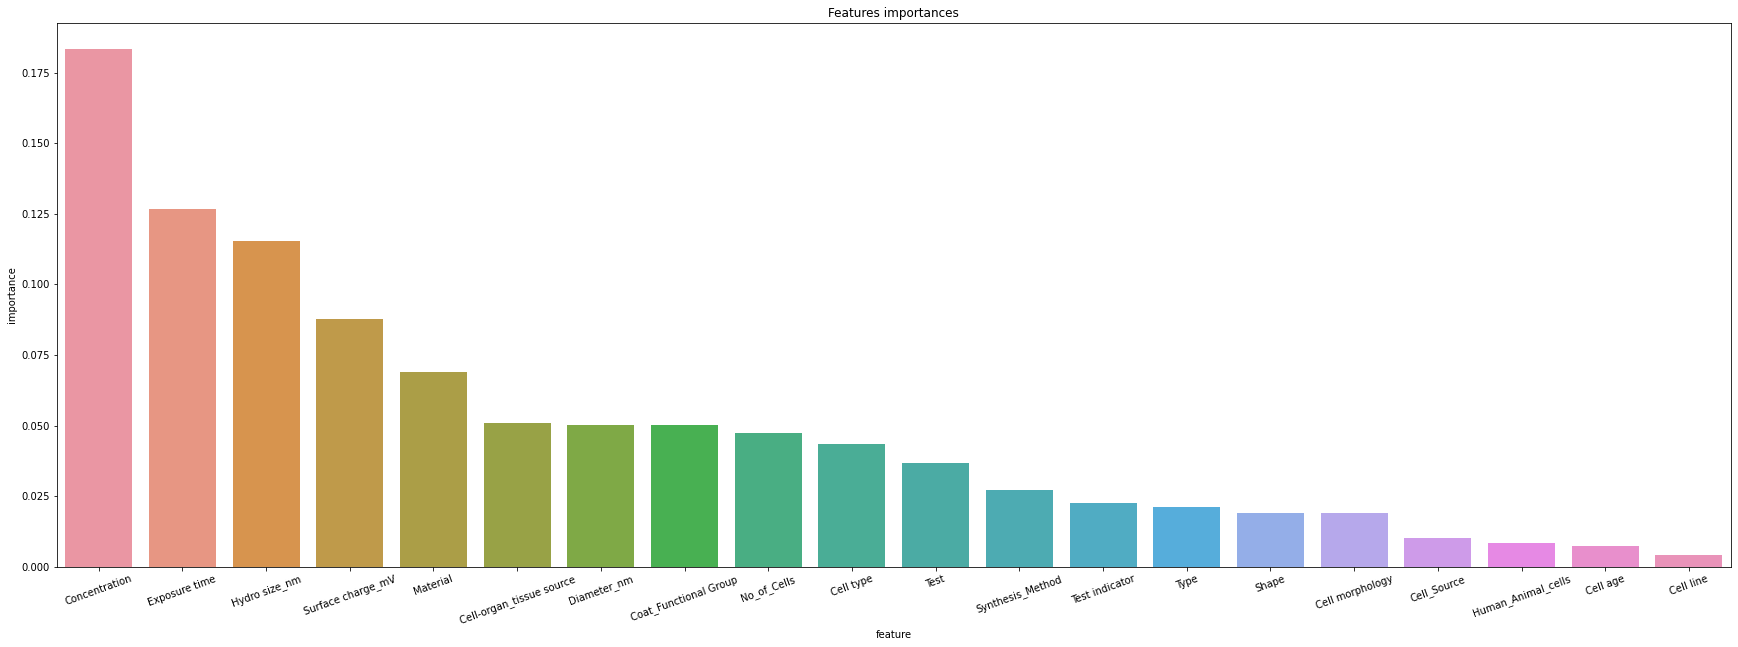

In [ ]:
plt.figure(figsize=(30,10))
sns.barplot(x='feature', y='importance', data=importances)
plt.xticks(rotation=20)
plt.title('Features importances');

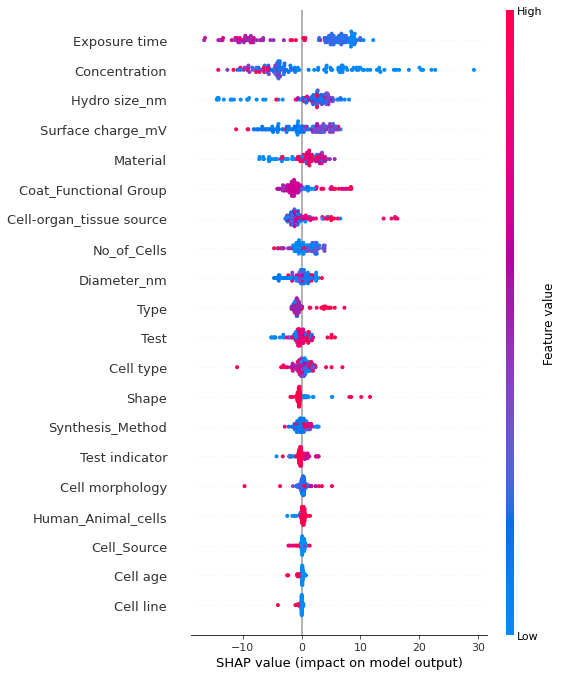

In [ ]:
# через shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test, X.columns)

# Обучение на важных признаках

In [ ]:
importances

,feature,importance
17,Concentration,0.183387
16,Exposure time,0.126645
6,Hydro size_nm,0.115196
7,Surface charge_mV,0.087668
0,Material,0.068876
12,Cell-organ_tissue source,0.050997
5,Diameter_nm,0.050244
3,Coat_Functional Group,0.050225
9,No_of_Cells,0.047404
8,Cell type,0.043534


In [ ]:
important_feat = importances.set_index('feature').T.drop(['Test', 
                                                          'Type', 
                                                          'Test indicator', 
                                                          'Synthesis_Method', 
                                                          'Human_Animal_cells'], axis=1).columns
X_new = X[important_feat]

In [ ]:
X_new.shape

(1298, 15)

In [ ]:
important_feat

Index(['Concentration', 'Exposure time', 'Hydro size_nm', 'Surface charge_mV',
       'Material', 'Cell-organ_tissue source', 'Diameter_nm',
       'Coat_Functional Group', 'No_of_Cells', 'Cell type', 'Shape',
       'Cell morphology', 'Cell_Source', 'Cell age', 'Cell line'],
      dtype='object', name='feature')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=RAND)

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
def objective(trial, X, y, N_FOLDS, random_state):
    
    rf_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [30, 50, 100, 200]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2']),
        "criterion": trial.suggest_categorical("criterion", ['mse']),
        "random_state": 42}
    
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = RandomForestRegressor(**rf_params)
        model.fit(X_train,
                  y_train)
        
        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="RF")
func = lambda trial: objective(trial, x_train, y_train, N_FOLDS=N_folds, random_state=RAND)
study.optimize(func, n_trials=30, show_progress_bar=True)

[I 2022-09-08 12:23:25,609] A new study created in memory with name: RF


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-09-08 12:23:26,097] Trial 0 finished with value: 15.586884197050846 and parameters: {'n_estimators': 50, 'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'criterion': 'mse'}. Best is trial 0 with value: 15.586884197050846.
[I 2022-09-08 12:23:26,718] Trial 1 finished with value: 11.264874804901341 and parameters: {'n_estimators': 30, 'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'criterion': 'mse'}. Best is trial 1 with value: 11.264874804901341.
[I 2022-09-08 12:23:27,482] Trial 2 finished with value: 12.812017458830514 and parameters: {'n_estimators': 100, 'bootstrap': False, 'max_depth': 7, 'max_features': 'log2', 'criterion': 'mse'}. Best is trial 1 with value: 11.264874804901341.
[I 2022-09-08 12:23:28,394] Trial 3 finished with value: 13.039516139881016 and parameters: {'n_estimators': 100, 'bootstrap': True, 'max_depth': 7, 'max_features': 'log2', 'criterion': 'mse'}. Best is trial 1 with value: 11.264874804901341.
[I 2022-09-08 12:23:30,235] Tri

In [ ]:
study.best_params

{'n_estimators': 50,
 'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'criterion': 'mse'}

In [ ]:
score_oof = []
predicts_test = []


for fold, (train_index, test_index) in enumerate(cv.split(x_train, y_train)):
    X_train_, X_val = x_train[train_index], x_train[test_index]
    y_train_, y_val = y_train[train_index], y_train[test_index]

    model = RandomForestRegressor(**study.best_params, random_state=RAND)
    model.fit(X_train_, y_train_)

    y_prob_val = model.predict(X_val)
    y_prob_test = model.predict(x_test)
    
    print(
        "Fold:", fold + 1, "MAE Validation %.3f" %
        mean_absolute_error(y_val, y_prob_val))
    print("---")

    score_oof.append(mean_absolute_error(y_val, y_prob_val))
    
    predicts_test.append(y_prob_test)

Fold: 1 MAE Validation 9.289
---
Fold: 2 MAE Validation 9.876
---
Fold: 3 MAE Validation 11.084
---
Fold: 4 MAE Validation 9.224
---
Fold: 5 MAE Validation 10.086
---


In [ ]:
test_pred = np.mean(predicts_test, axis=0)
print(f'МAE = {mean_absolute_error(y_test, test_pred)}')
print(f'WAPE = {wape(y_test, test_pred)}')
print(f'R2 = {r2_adjusted(y_test, test_pred, x_test)}')

МAE = 10.65266182758714
WAPE = 0.14285817920036523
R2 = 0.7309633135613525


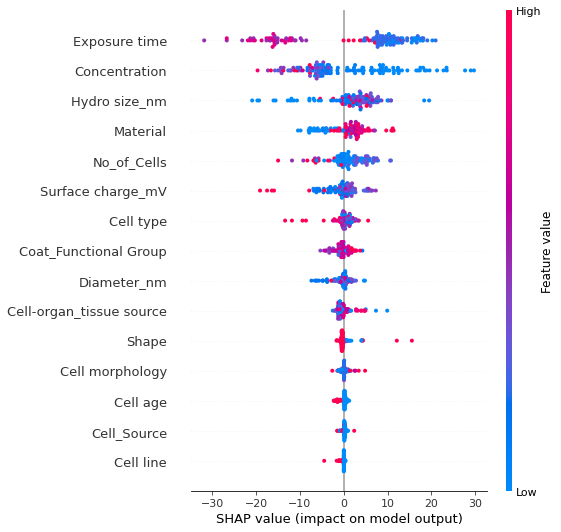

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test, X_new.columns)

In [ ]:
joblib.dump(study.best_params, 
            '/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/Models/RF_params_1.json')

['/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/Models/RF_params_1.json']

In [ ]:
params = joblib.load(
    '/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/Models/RF_params_1.json')
params

{'n_estimators': 50,
 'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'criterion': 'mse'}

In [ ]:
dict_uniq = {}
for i in X[important_feat].columns:
  if X[i].dtype != 'object':
    dict_uniq[i] = (X[i].unique().min(), X[i].unique().max())
  else:
    dict_uniq[i] = X[i].unique()

In [ ]:
joblib.dump(dict_uniq, '/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/uniq.json',)

['/content/drive/MyDrive/Colab Notebooks/Хакатон ИТМО/uniq.json']

In [ ]:
dict_uniq

{'Concentration': (0.028, 1500.0),
 'Exposure time': (3.0, 96.0),
 'Hydro size_nm': (7.0, 889.03),
 'Surface charge_mV': (-73.8, 63.8),
 'Material': (0, 19),
 'Cell-organ_tissue source': (0, 18),
 'Diameter_nm': (4.0, 280.0),
 'Coat_Functional Group': (0, 15),
 'No_of_Cells': (2600.0, 350000.0),
 'Cell type': (0, 32),
 'Shape': (0, 6),
 'Cell morphology': (0, 7),
 'Cell_Source': (0, 4),
 'Cell age': (0, 2),
 'Cell line': (0, 1)}

In [ ]:
X.columns.to_list()

['Material',
 'Type',
 'Shape',
 'Coat_Functional Group',
 'Synthesis_Method',
 'Diameter_nm',
 'Hydro size_nm',
 'Surface charge_mV',
 'Cell type',
 'No_of_Cells',
 'Human_Animal_cells',
 'Cell_Source',
 'Cell-organ_tissue source',
 'Cell morphology',
 'Cell age',
 'Cell line',
 'Exposure time',
 'Concentration',
 'Test',
 'Test indicator']

In [ ]:
data_3[important_feat]['Material'].nunique()

20